In [1]:
import pandas as pd

# save the patients_df
df = pd.read_csv('./data/msk_2024_fe_15.csv')
os_months_index = df.columns.get_loc("OS_MONTHS")

gene_mutations = df.iloc[:, 1:os_months_index]  # Exclude the first column (ID) and OS_MONTHS
data_labels = df.iloc[:, os_months_index:]  # Include only the OS_MONTHS column as labels

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------

# Extract patient IDs
patient_ids = df['Patient'].values

# Get binary mutation features; convert to float32 for PyTorch
GMP = gene_mutations

CD_BINARY = data_labels[['highest_stage_recorded', 'CNS_BRAIN', 'LIVER', 'LUNG', 'Regional', 'Distant', 'CANCER_TYPE_BREAST', 'CANCER_TYPE_COLON', 'CANCER_TYPE_LUNG', 'CANCER_TYPE_PANCREAS', 'CANCER_TYPE_PROSTATE']]
CD_NUMERIC = data_labels[['CURRENT_AGE_DEID', 'TMB_NONSYNONYMOUS', 'FRACTION_GENOME_ALTERED']]

GMP = GMP.values.astype(np.float32)
CD_BINARY = CD_BINARY.values.astype(np.float32)
CD_NUMERIC = CD_NUMERIC.values.astype(np.float32)

# --- Process CURRENT_AGE_DEID (left-skewed) ---
# Reflect the age values: higher ages become lower values.
max_age = np.max(CD_NUMERIC[:, 0])
age_reflected = max_age - CD_NUMERIC[:, 0]

# Apply log transformation to the reflected age.
age_log = np.log1p(age_reflected)  # log1p ensures numerical stability for zero values.

# Standardize the transformed age.
scaler_age = StandardScaler()
age_normalized = scaler_age.fit_transform(age_log.reshape(-1, 1))

# --- Process TMB_NONSYNONYMOUS and FRACTION_GENOME_ALTERED (right-skewed) ---
# Apply log1p transformation to both features.
tmb_log = np.log1p(CD_NUMERIC[:, 1])
frac_log = np.log1p(CD_NUMERIC[:, 2])

# Standardize the transformed features.
scaler_tmb = StandardScaler()
tmb_normalized = scaler_tmb.fit_transform(tmb_log.reshape(-1, 1))

scaler_frac = StandardScaler()
frac_normalized = scaler_frac.fit_transform(frac_log.reshape(-1, 1))

# --- Combine normalized features ---
# The resulting cd_numeric_normalized will have the same shape as the original.
CD_NUMERIC = np.hstack([age_normalized, tmb_normalized, frac_normalized])
CD = np.hstack([CD_BINARY, CD_NUMERIC])
X = np.hstack([GMP, CD])  # Combine gene mutations and clinical data

y_os = data_labels["OS_MONTHS"].values  # Overall survival time
y_status = data_labels["OS_STATUS"].values  # Overall survival status (0 = alive (censored), 1 = dead (event))

# Train-Validation-Test Split
X_train, X_temp, y_os_train, y_os_temp, y_status_train, y_status_temp = train_test_split(
    X, y_os, y_status, test_size=0.3
)
X_val, X_test, y_os_val, y_os_test, y_status_val, y_status_test = train_test_split(
    X_temp, y_os_temp, y_status_temp, test_size=0.5
)

# Convert to PyTorch tensors
X_train, y_os_train, y_status_train = map(torch.tensor, (X_train, y_os_train, y_status_train))
X_val, y_os_val, y_status_val = map(torch.tensor, (X_val, y_os_val, y_status_val))
X_test, y_os_test, y_status_test = map(torch.tensor, (X_test, y_os_test, y_status_test))

# Move to float tensors
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()
y_os_train, y_os_val, y_os_test = y_os_train.float(), y_os_val.float(), y_os_test.float()
y_status_train, y_status_val, y_status_test = y_status_train.float(), y_status_val.float(), y_status_test.float()

print(f"Train Size: {X_train.shape}, Validation Size: {X_val.shape}, Test Size: {X_test.shape}")


Train Size: torch.Size([15598, 980]), Validation Size: torch.Size([3343, 980]), Test Size: torch.Size([3343, 980])


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# 0. MLP-Based Survival Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1 = 256, hidden_dim2 = 256, dropout=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# 2. LSTM-Based Survival Model
class LSTMSurvival(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1):
        super(LSTMSurvival, self).__init__()
        # Each feature is treated as a time step with dimension=1.
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x: (batch, input_dim) -> reshape to (batch, seq_len, 1)
        x = x.unsqueeze(-1)  # (batch, input_dim, 1)
        output, (hn, cn) = self.lstm(x)
        risk = self.fc(hn[-1])
        return risk.squeeze(-1)
    
# 3. self-Attention-Based Survival Model
class ImprovedAttentionBlock(nn.Module):
    """
    Transformer-like block with:
      1) Multi-head Self-Attention (with dropout)
      2) Residual Connection + LayerNorm
      3) Feed-forward Subnetwork (with GELU activation and dropout)
      4) Another Residual Connection + LayerNorm
    """
    def __init__(self, embed_dim, num_heads=1, dropout=0.1, ff_hidden_multiplier=4):
        super(ImprovedAttentionBlock, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim,
                                         num_heads=num_heads,
                                         dropout=dropout,
                                         batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden_multiplier * embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_hidden_multiplier * embed_dim, embed_dim)
        )
        self.ln2 = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # Self-attention sublayer.
        attn_output, _ = self.mha(x, x, x)
        x = self.ln1(x + self.dropout(attn_output))
        # Feed-forward sublayer.
        ff_output = self.ff(x)
        out = self.ln2(x + self.dropout(ff_output))
        return out

class SelfAttentionSurvival(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, num_heads=4):
        super(SelfAttentionSurvival, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.attention_blocks = nn.Sequential(*[ImprovedAttentionBlock(embed_dim=hidden_dim, num_heads=num_heads) for _ in range(num_layers)])
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.attention_blocks(x)
        risk = self.fc(x).squeeze(-1)
        return risk    
    
# 3. Transformer-Based Survival Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # For odd d_model, handle the extra dimension
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return x

# ---------------------------
# Model Architecture: GeneRiskNet
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.3):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = self.bn2(self.fc2(out))
        out = out + residual  # Residual connection
        return F.relu(out)

class GeneRiskNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_residual_blocks=3, dropout_rate=0.3):
        super(GeneRiskNet, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.bn_in = nn.BatchNorm1d(hidden_dim)
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_dim, dropout_rate) for _ in range(num_residual_blocks)])
        self.fc_out = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.bn_in(self.fc_in(x)))
        x = self.res_blocks(x)
        risk = self.fc_out(x)
        return risk.squeeze(-1)  # Output shape: (batch,)
    
class TransformerPredictionModel(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=2, mlp_hidden_dim=256, dropout=0.1):
        super(TransformerPredictionModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        
        # Map each scalar feature to a d_model-dimensional embedding.
        # We reshape the input to (batch, input_dim, 1) and then apply this linear projection.
        self.feature_embedding = nn.Linear(1, d_model)
        
        # Learnable [CLS] token, used to aggregate information from the entire sequence.
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        
        # Positional embedding: one embedding per token.
        # We have input_dim tokens + 1 CLS token.
        self.pos_embedding = nn.Parameter(torch.zeros(1, input_dim + 1, d_model))
        
        # Transformer encoder.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final head to output the risk score.
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, 1)
        )
        
    def forward(self, x):
        # x: (batch_size, input_dim)
        batch_size = x.size(0)
        
        # Reshape input: each feature becomes a token.
        x = x.unsqueeze(-1)  # (batch_size, input_dim, 1)
        
        # Embed each feature (token) into d_model-dimensional space.
        x = self.feature_embedding(x)  # (batch_size, input_dim, d_model)
        
        # Create a batch of CLS tokens and prepend to the sequence.
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, d_model)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, input_dim + 1, d_model)
        
        # Add positional embeddings.
        x = x + self.pos_embedding  # (batch_size, input_dim + 1, d_model)
        
        # Transformer expects shape (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)  # (input_dim + 1, batch_size, d_model)
        
        # Pass through transformer encoder.
        x = self.transformer_encoder(x)  # (input_dim + 1, batch_size, d_model)
        
        # Extract the output of the CLS token (first token) for prediction.
        cls_out = x[0]  # (batch_size, d_model)
        
        # Pass through the MLP head to get the risk score.
        risk = self.head(cls_out)  # (batch_size, 1)
        return risk.squeeze(-1)  # (batch_size,)

In [14]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train, y_os_train, y_status_train = X_train.to(device), y_os_train.to(device), y_status_train.to(device)
X_val, y_os_val, y_status_val = X_val.to(device), y_os_val.to(device), y_status_val.to(device)
X_test, y_os_test, y_status_test = X_test.to(device), y_os_test.to(device), y_status_test.to(device)

# normalize the y_os_train, y_os_val, y_os_test using log1p
y_os_train = torch.log1p(y_os_train)
y_os_val = torch.log1p(y_os_val)
y_os_test = torch.log1p(y_os_test)

Using device: cpu


In [15]:
def cox_partial_likelihood_loss(risk_scores, times, events):
    """
    Computes the Cox Partial Likelihood loss for survival analysis.

    Parameters:
    - risk_scores: Tensor of predicted risk scores (higher = higher risk).
    - times: Tensor of survival times.
    - events: Tensor indicating event occurrence (1 = event, 0 = censored).

    Returns:
    - Negative log Cox partial likelihood loss.
    """
    # Sort survival times in descending order
    sorted_indices = torch.argsort(times, descending=True)
    sorted_risk = risk_scores[sorted_indices]
    sorted_events = events[sorted_indices]

    # Compute log-cumulative sum of exp(risk) -> LogSumExp trick for numerical stability
    risk_cumsum = torch.logcumsumexp(sorted_risk, dim=0)

    # Select only events (uncensored cases)
    event_mask = sorted_events == 1
    loss = -torch.sum(sorted_risk[event_mask] - risk_cumsum[event_mask])

    return loss / (event_mask.sum() + 1e-8)  # Normalize by number of events



def smooth_concordance_loss(risk_scores, times, events, sigma=0.1, eps=1e-8):
    """
    Computes a smooth, differentiable surrogate for the concordance index.
    
    For each valid pair (i, j) (with times[i] < times[j] and event[i] == 1),
    the loss is defined as:
    
        L = mean( sigmoid((risk_scores[j] - risk_scores[i]) / sigma) )
    
    This encourages risk_scores[i] to be larger than risk_scores[j].
    
    Parameters:
      risk_scores: Tensor of shape [N] (predicted risk scores).
      times: Tensor of shape [N] (survival times).
      events: Tensor of shape [N] (event indicators, 1 if event, 0 if censored).
      sigma: Temperature parameter controlling the smoothness of the penalty.
      eps: Small constant to avoid division by zero.
      
    Returns:
      Mean smooth concordance loss (scalar).
    """
    risk_scores = risk_scores.squeeze()
    times = times.squeeze()
    events = events.squeeze()
    
    time_i = times.unsqueeze(0)  # [1, N]
    time_j = times.unsqueeze(1)  # [N, 1]
    event_i = events.unsqueeze(0)  # [1, N]
    
    # Valid pairs: time_i < time_j and event_i == 1
    valid_pairs = (time_i < time_j) & (event_i == 1)
    
    if valid_pairs.sum() == 0:
        return torch.tensor(0.0, device=risk_scores.device)
    
    # Compute pairwise difference: (risk_scores[j] - risk_scores[i])
    diff = risk_scores.unsqueeze(1) - risk_scores.unsqueeze(0)
    loss = torch.sigmoid(diff / sigma)
    loss = loss[valid_pairs]
    return loss.mean()
  
def deepsurv_loss(risk_scores, times, events, model, l2_reg=1e-4):
    loss = cox_partial_likelihood_loss(risk_scores, times, events)
    l2_penalty = sum(param.norm(2) for param in model.parameters()) * l2_reg
    return loss + l2_penalty

In [16]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for Survival Data
class SurvivalDataset(Dataset):
    def __init__(self, X, time, event):
        self.X = X
        self.time = time
        self.event = event
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.time[idx], self.event[idx]

batch_size = 3000  # Adjust based on your memory constraints

# Create dataset objects
train_dataset = SurvivalDataset(X_train, y_os_train, y_status_train)
val_dataset   = SurvivalDataset(X_val, y_os_val, y_status_val)
test_dataset  = SurvivalDataset(X_test, y_os_test, y_status_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# For validation and test we use full batches (since they are smaller)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [17]:
# -------------------------
# Select Model Type: "MLP", "CNN", "LSTM", or "Transformer"
# -------------------------
model_type = "MLP"  # Change to "MLP", "CNN", or "LSTM" as desired

# Assume X_train exists; if not, default to an example input dimension of 10.
input_dim = X_train.shape[1] if 'X_train' in globals() else 10

if model_type == "MLP":
    model = MLP(input_dim, hidden_dim1=128, hidden_dim2=64)
elif model_type == "Transformer":
    model = TransformerPredictionModel(input_dim = input_dim, d_model=4, nhead=4, num_layers=2, mlp_hidden_dim=128, dropout=0.3)
elif model_type == "RES":
    model = GeneRiskNet(input_dim, hidden_dim=256, num_residual_blocks=3, dropout_rate=0.3)
elif model_type == "LSTM":
    model = LSTMSurvival(input_dim, hidden_size=128, num_layers=2)
elif model_type == "SA":
    model = SelfAttentionSurvival(input_dim, hidden_dim=128, num_layers=1, num_heads=4)
else:
    raise ValueError("Invalid model type selected.")

print(model)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

x = torch.randn(batch_size, input_dim).to(device)
risk = model(x)
print(risk.shape)  # Expected output: torch.Size([4096])

MLP(
  (fc1): Linear(in_features=980, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
torch.Size([3000, 1])


In [18]:
from lifelines.utils import concordance_index

num_epochs = 100
l2_lambda = 1e-4

train_losses, val_losses, val_c_indices = [], [], []

best_model = None
best_val_loss = float('inf')
best_c_index = 0.0

for epoch in range(num_epochs):
    # ---- Training Phase ----
    epoch_loss = 0.0
    model.train()

    for batch_X, batch_time, batch_event in train_loader:
        batch_X, batch_time, batch_event = batch_X.to(device), batch_time.to(device), batch_event.to(device)
        optimizer.zero_grad()
        risk = model(batch_X)
        # loss = hybrid_survival_loss(risk, batch_time, batch_event, alpha=0.5, margin=0.0)
        loss = cox_partial_likelihood_loss(risk, batch_time, batch_event)
        
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param,2) ** 2
        loss += l2_reg * l2_lambda
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(train_dataset)
        
    # optimizer.zero_grad()
    # risk = model(X_train)
    # loss = cox_partial_likelihood_loss(risk, y_os_train, y_status_train)
    # # loss = smooth_concordance_loss(risk, y_os_train, y_status_train)
    # l2_reg = 0.0
    # for param in model.parameters():
    #     l2_reg += torch.norm(param,2) ** 2
    # loss += l2_reg * l2_lambda
    # loss.backward()
    # optimizer.step()
    # epoch_loss = loss.item()

    train_losses.append(epoch_loss)
    
    # ---- Validation Phase ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # We compute validation loss and predictions on the full validation set
        for val_X, val_time, val_event in val_loader:
            val_X, val_time, val_event = val_X.to(device), val_time.to(device), val_event.to(device)
            val_risk = model(val_X)
            loss = cox_partial_likelihood_loss(val_risk, val_time, val_event)
            # loss = smooth_concordance_loss(val_risk, val_time, val_event)
            
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param,2) ** 2
            val_loss = loss + l2_reg * l2_lambda
                        
            # Convert log-transformed times back to original scale for c-index
            val_risk_np = val_risk.cpu().numpy()
            val_time_np = val_time.cpu().numpy()
            val_event_np = val_event.cpu().numpy()
            val_time_orig = np.expm1(val_time_np)
            c_index = concordance_index(val_time_orig, -val_risk_np, val_event_np)
    
    val_losses.append(val_loss.item())
    val_c_indices.append(c_index)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f}, Val Loss {val_loss.item():.4f}, "
            f"c-index {c_index:.4f}")
        
    if val_loss < best_val_loss and c_index > best_c_index:
        best_val_loss = val_loss.item()
        best_c_index = c_index
        best_model = model.state_dict()
        print(f"New best model found at epoch {epoch+1} with val_loss: {best_val_loss:.4f} and c-index: {best_c_index:.4f}")

New best model found at epoch 1 with val_loss: 7.5551 and c-index: 0.6872
New best model found at epoch 2 with val_loss: 7.5344 and c-index: 0.7061
New best model found at epoch 3 with val_loss: 7.5052 and c-index: 0.7138
New best model found at epoch 4 with val_loss: 7.4664 and c-index: 0.7228
New best model found at epoch 5 with val_loss: 7.4176 and c-index: 0.7244
New best model found at epoch 6 with val_loss: 7.3628 and c-index: 0.7257
New best model found at epoch 7 with val_loss: 7.3113 and c-index: 0.7265
New best model found at epoch 8 with val_loss: 7.2670 and c-index: 0.7276
New best model found at epoch 9 with val_loss: 7.2367 and c-index: 0.7286
Epoch 10/100: Train Loss 6.8680, Val Loss 7.2193, c-index 0.7294
New best model found at epoch 10 with val_loss: 7.2193 and c-index: 0.7294
Epoch 20/100: Train Loss 6.6270, Val Loss 7.3322, c-index 0.7214
Epoch 30/100: Train Loss 6.4530, Val Loss 7.5002, c-index 0.7136
Epoch 40/100: Train Loss 6.3110, Val Loss 7.7197, c-index 0.7099

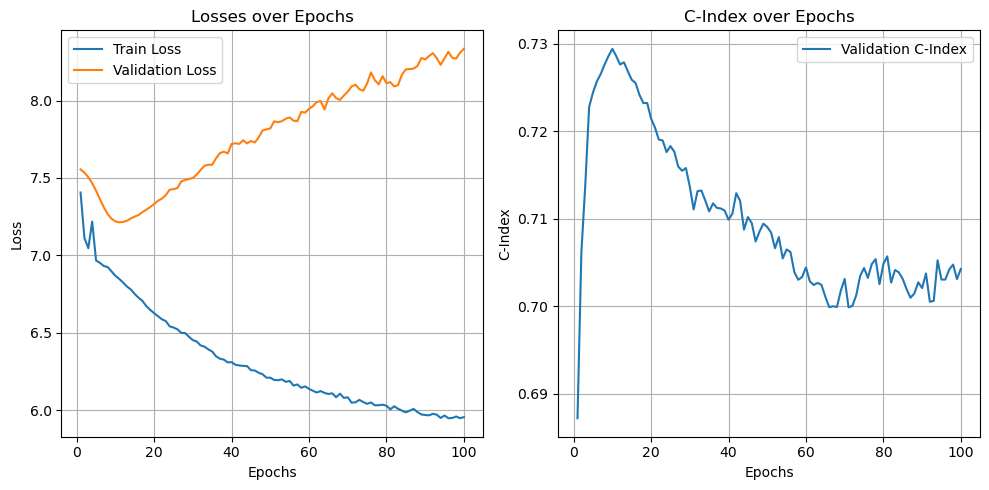

In [19]:
epoch_arr = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_arr, train_losses, label='Train Loss')
plt.plot(epoch_arr, val_losses, label='Validation Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_arr, val_c_indices, label='Validation C-Index')
plt.title('C-Index over Epochs')
plt.xlabel('Epochs')
plt.ylabel('C-Index')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [24]:
# test the model on the test set
model.load_state_dict(best_model) if best_model is not None else None
model.eval()  # Set to evaluation mode

with torch.no_grad():
    for test_X, test_time, test_event in test_loader:
        test_X, test_time, test_event = test_X.to(device), test_time.to(device), test_event.to(device)
        test_risk = model(test_X)
        # Compute loss on the test set
        
        test_risk_np = test_risk.cpu().numpy().squeeze()    # risk scores: shape (batch,)
        test_time_np = test_time.cpu().numpy().squeeze()      # survival times (log-transformed)
        test_event_np = test_event.cpu().numpy().squeeze()    # event indicators
        test_time_orig = np.expm1(test_time_np)
        c_index_whole = concordance_index(test_time_orig, -test_risk_np, test_event_np)

        print(f"Test c-index: {c_index_whole:.4f}")

# Save the model
# torch.save(model.state_dict(), f'../models/checkpoints/survival_model_subtype_mlp.pth')

Test c-index: 0.7073


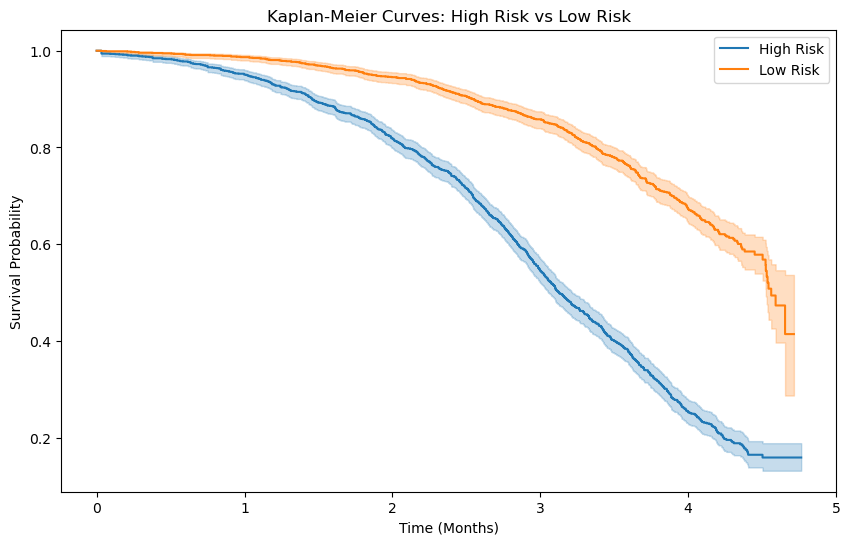

Log-rank test p-value: 1.8671188226815513e-122


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

all_risk = []
all_time = []
all_event = []

# test the model on the test set
model.load_state_dict(best_model) if best_model is not None else None
model.eval()  # Set to evaluation mode

with torch.no_grad():
    for test_X, test_time, test_event in test_loader:
        test_X, test_time, test_event = test_X.to(device), test_time.to(device), test_event.to(device)
        test_risk = model(test_X)
        # Convert outputs to numpy arrays and squeeze to remove extra dimensions.
        test_risk_np = test_risk.cpu().numpy().squeeze()    # risk scores: shape (batch,)
        test_time_np = test_time.cpu().numpy().squeeze()      # survival times (log-transformed)
        test_event_np = test_event.cpu().numpy().squeeze()    # event indicators
        
        # Convert survival times back to original scale (if you applied log1p transformation)
        test_time_orig = np.expm1(test_time_np)
        
        all_risk.append(test_risk_np)
        all_time.append(test_time_orig)
        all_event.append(test_event_np)
        
# Concatenate predictions from all batches.
all_risk = np.concatenate(all_risk, axis=0)
all_time = np.concatenate(all_time, axis=0)
all_event = np.concatenate(all_event, axis=0)

# --- Stratify patients into risk groups ---
# Here we use the median risk score as the cutoff.
median_risk = np.median(all_risk)
group_labels = np.where(all_risk > median_risk, "High Risk", "Low Risk")

# --- Fit Kaplan-Meier curves for each group ---
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

high_mask = group_labels == "High Risk"
low_mask = group_labels == "Low Risk"

kmf_high.fit(durations=all_time[high_mask],
             event_observed=all_event[high_mask],
             label="High Risk")
kmf_low.fit(durations=all_time[low_mask],
            event_observed=all_event[low_mask],
            label="Low Risk")

# --- Plot the Kaplan-Meier curves ---
plt.figure(figsize=(10, 6))
ax = kmf_high.plot_survival_function(ci_show=True)
kmf_low.plot_survival_function(ax=ax, ci_show=True)
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Curves: High Risk vs Low Risk")
plt.show()

# --- Optionally, print the log-rank test result to compare curves ---
from lifelines.statistics import logrank_test
results = logrank_test(all_time[high_mask], all_time[low_mask],
                       event_observed_A=all_event[high_mask],
                       event_observed_B=all_event[low_mask])
print("Log-rank test p-value:", results.p_value)